In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sys import stdout

from network import HandModel
from preprocess_data import DataLoader


2025-07-21 20:36:04.337698: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-21 20:36:04.350225: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-21 20:36:04.354330: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-21 20:36:04.364338: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
model = HandModel()
dummy_input = tf.random.normal([1, 368, 368, 3])
_ = model(dummy_input)

loss_graph = []

model.load_weights('curr_vgg19_train_epoch_20.h5')

In [2]:
loader = DataLoader("hand_labels_synth/synth2/", 32, 0.8)
train_data, val_data = loader.get_data_set()
num_batches = loader.get_num_batches()

I0000 00:00:1753155366.980109  491613 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1753155367.024810  491613 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1753155367.027500  491613 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1753155367.031329  491613 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

[[ 85.21452332 173.12060547   1.        ]
 [ 87.69029236 148.85780334   1.        ]
 [ 76.8404541  130.85449219   1.        ]
 [101.13573456 125.7907486    1.        ]
 [137.0382843  128.00276184   1.        ]
 [118.5532608  184.532547     1.        ]
 [142.43692017 187.96066284   1.        ]
 [167.59210205 178.79924011   1.        ]
 [196.06517029 162.23907471   1.        ]
 [147.82598877 200.03800964   1.        ]
 [191.43353271 212.16567993   1.        ]
 [223.47140503 205.14064026   1.        ]
 [254.28117371 192.29589844   1.        ]
 [171.59661865 207.18063354   1.        ]
 [219.74983215 217.37692261   1.        ]
 [250.63174438 209.32655334   1.        ]
 [280.5866394  197.31211853   1.        ]
 [189.62809753 210.22674561   1.        ]
 [232.78018188 204.87371826   1.        ]
 [252.85021973 186.22302246   1.        ]
 [249.9256134  160.24780273   1.        ]]


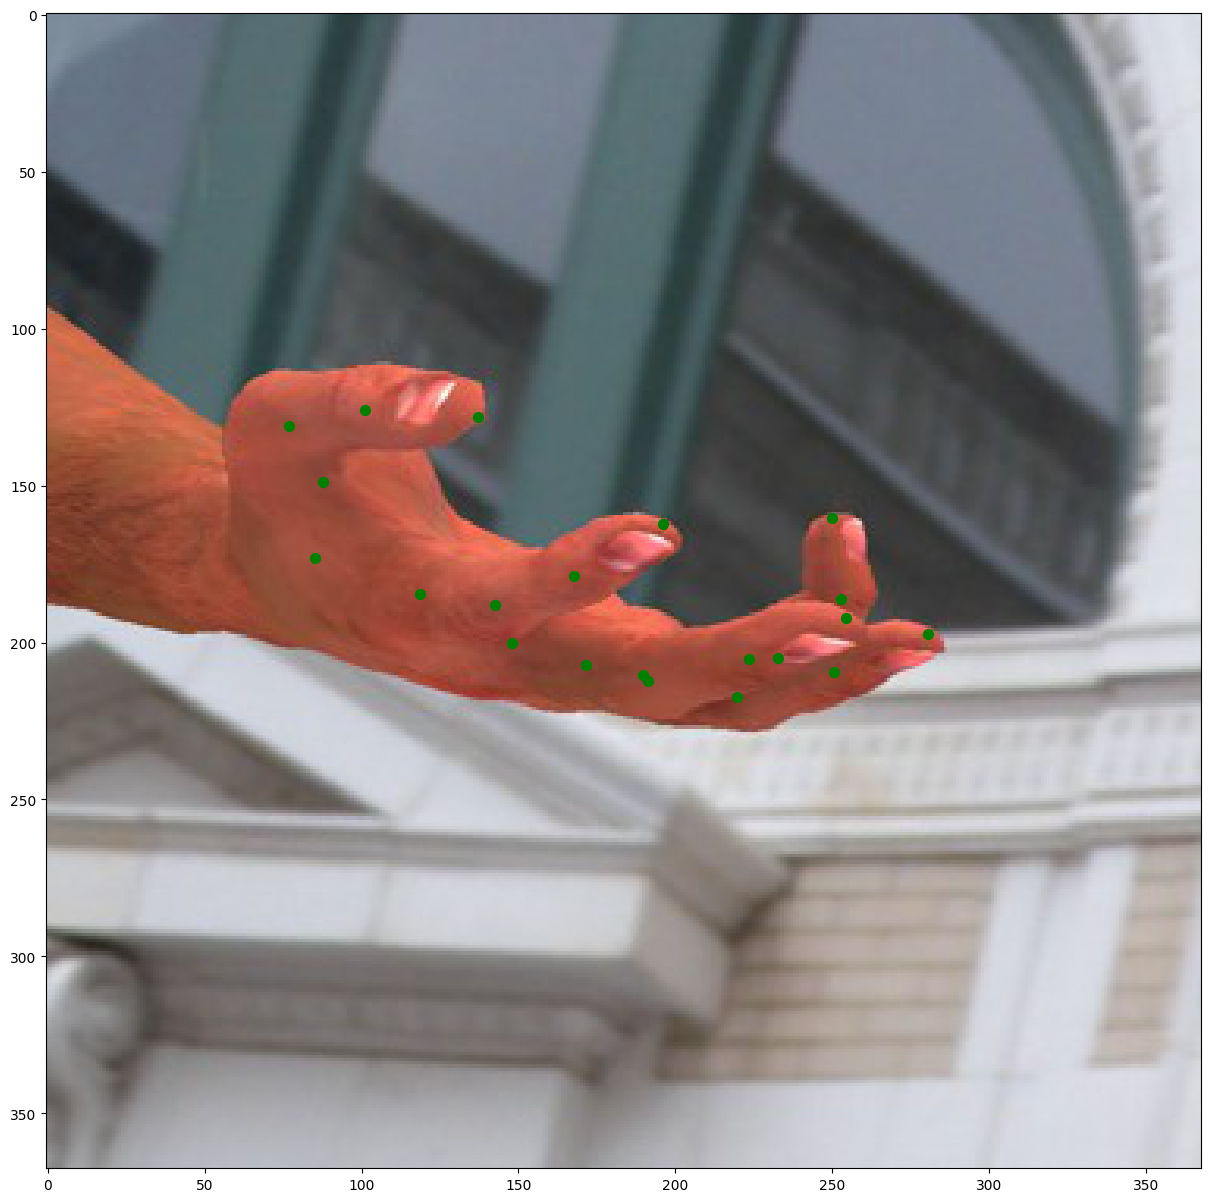

In [5]:
fig, axes = plt.subplots(1, 1, figsize=(15,15))

test_x, test_y, test_handpos = loader.get_random_data()

test_x = np.expand_dims(test_x, axis = 0)

print(test_handpos)

test_handpos = test_handpos.T
axes.imshow(test_x[0,:,:,::-1])
axes.scatter(test_handpos[0], test_handpos[1], color='green', s=50)
test_handpos = test_handpos.T

plt.show()

In [ ]:
num_epochs = 20
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=0.0001,
    decay_steps=(loader.get_num_batches() * num_epochs),  # total_epochs × steps_per_epoch
    alpha=0.0
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, epsilon=1e-8)

train_loss = tf.keras.metrics.Mean(name='train_loss')

In [ ]:
for image, label in train_data.take(1):
    img_array = image.numpy()
    lbl = label.numpy()
    print(img_array.shape)
    print(lbl.shape)

    plt.imshow(img_array[0].astype(np.uint8))

In [ ]:
model.summary()

In [ ]:
copy_model = tf.keras.applications.VGG19(False, input_shape=(368, 368, 3), pooling='avg')

In [ ]:
for i in range(1, 16):
    print(copy_model.layers[i].name)
    print(model.feature_extraction.layers[i - 1].name)
    print(model.feature_extraction.layers[i - 1].get_weights())
    model.feature_extraction.layers[i - 1].set_weights(copy_model.layers[i].get_weights())
    print(model.feature_extraction.layers[i - 1].get_weights())

In [ ]:
def compute_loss(y_pred, intermediate_pred, y):
    loss_object = tf.keras.losses.MeanSquaredError()
    final_loss = loss_object(y, y_pred)
    total_loss = final_loss
    for i in range(len(intermediate_pred)):
        total_loss += loss_object(y, intermediate_pred[i])
    
    return final_loss, total_loss

In [ ]:
def l2_loss(y_pred, intermediate_pred, y, punisment = 0.001):

    batch_size = tf.cast(tf.shape(y)[0], tf.float32)
    

    total_loss = 0
    for y_hat in intermediate_pred:
        total_loss += tf.nn.l2_loss(y - y_hat)

    final_loss = tf.nn.l2_loss(y - y_pred)

    total_loss += final_loss
    
    total_loss /= (len(intermediate_pred) + 1)

    total_loss /= batch_size
    final_loss /= batch_size

    return final_loss, total_loss

In [ ]:
def l2_punishment_loss(y_pred, intermediate_pred, y, punisment = 0.001):

    batch_size = tf.cast(tf.shape(y)[0], tf.float32)
    

    total_loss = 0
    pos_val = 0
    for y_hat in intermediate_pred:
        total_loss += tf.nn.l2_loss(y - y_hat)
        pos_val += tf.reduce_sum(y_hat[:, :, :, :-1])

    final_loss = tf.nn.l2_loss(y - y_pred)
    pos_val += tf.reduce_sum(y_pred[:, :, :, :-1])

    total_loss += final_loss
    total_loss += pos_val * punisment

    total_loss /= batch_size
    final_loss /= batch_size

    return final_loss, total_loss

In [ ]:
@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        y_pred, y_intermediate = model(x)
        fin_loss, total_loss = compute_loss(y_pred, y_intermediate, y)

    gradients = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return fin_loss, total_loss

In [ ]:
old_loss = 0
for epoch in range(num_epochs):
    train_loss.reset_state()


    for batch_num, (x_batch, y_batch) in enumerate(train_data):
        fin_loss, total_loss = train_step(x_batch, y_batch)
        train_loss(total_loss)
        print(f"\rProgress: {batch_num + 1}/{num_batches}", end='', flush=True)

    print()

    curr_loss = train_loss.result()

    print(f"Epoch {epoch + 1} ----- Loss: {curr_loss}")
    loss_graph.append(curr_loss)

    if curr_loss < old_loss:
        model.save(f"curr_vgg19_train_epoch_{epoch + 1}.h5")

    old_loss = curr_loss

    if curr_loss < 0.0001:
        print("Finished training, ended early")
        break


In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(loss_graph, label='Training Loss', color='blue', marker='o')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [ ]:
model.save("vgg19_pretrain_synth_dataset_epoch35_lr_custom_norm.h5")

In [ ]:
from visualize_data import visualize_combined_map
from model_utils import get_points_from_map

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(15,15))

test_x, test_y, test_handpos = loader.get_random_data()

test_x = np.expand_dims(test_x, axis = 0)


y_pred, _ = model(test_x)

print(test_handpos)

test_handpos = test_handpos.T
axes[0].imshow(test_x[0,:,:,::-1])
axes[0].scatter(test_handpos[1], test_handpos[0], color='green', s=50)
test_handpos = test_handpos.T

visualize_combined_map(test_x[0,:,:,::-1], test_y, axes[1])
visualize_combined_map(test_x[0,:,:,::-1], y_pred[0, :, :, :-1], axes[2])

pred_handpose = get_points_from_map(y_pred[0].numpy(), test_x.shape[1:3])
pred_handpose = pred_handpose.T
axes[3].imshow(test_x[0,:,:,::-1])
axes[3].scatter(pred_handpose[0][0], pred_handpose[1][0], color='green', s=50)
axes[3].scatter(pred_handpose[0][1:5], pred_handpose[1][1:5], color='red', s=50)
axes[3].scatter(pred_handpose[0][5:9], pred_handpose[1][5:9], color='blue', s=50)
axes[3].scatter(pred_handpose[0][9:13], pred_handpose[1][9:13], color='red', s=50)
axes[3].scatter(pred_handpose[0][13:17], pred_handpose[1][13:17], color='blue', s=50)
axes[3].scatter(pred_handpose[0][17:21], pred_handpose[1][17:21], color='red', s=50)
pred_handpose = pred_handpose.T


plt.tight_layout()
plt.show()

In [ ]:
fig, axes = plt.subplots(3, 7, figsize=(15,15))

for i, ax in enumerate(list(axes.flat)):
    ax.imshow(y_pred[0, :, :, i], cmap='gray')
    
    ax.axis('off')


plt.tight_layout()
plt.show()

In [ ]:
dummy_input = tf.random.normal((1, 368, 368, 3))
model1 = HandModel()
model1(dummy_input)
model1.load_weights("good progress models/vgg19_train_full_dataset2.h5")
model2 = HandModel()
model2(dummy_input)
model2.load_weights("good progress models/vgg19_train_full_dataset4.h5")

In [ ]:
fig, axes = plt.subplots(4, 11, figsize=(15,15))

test_x, test_y, test_handpos = loader.get_random_data()

test_x = np.expand_dims(test_x, axis = 0)

y_pred1, _ = model1(test_x)
y_pred2, _ = model2(test_x)


for i, ax in enumerate(list(axes.flat)):
    if i%2 == 0:
        ax.imshow(y_pred1[0, :, :, i//2], cmap='gray')
    else:
        ax.imshow(y_pred2[0, :, :, i//2], cmap='gray')
    
    ax.axis('off')


plt.tight_layout()
plt.show()

In [ ]:
import cv2 as cv

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15,15))

img_path = "test_photo.jpeg"

test_x = cv.imread(img_path)
# test_x = normalize_data(test_x)

test_x = np.expand_dims(test_x, axis = 0)

y_pred, _ = model(test_x)

axes[0].imshow(test_x[0, :, :, ::-1])

visualize_combined_map(test_x[0, :, :, ::-1], y_pred[0, :, :, :-1], axes[1])


plt.tight_layout()
plt.show()

In [ ]:
fig, axes = plt.subplots(3, 7, figsize=(15,15))

for i, ax in enumerate(list(axes.flat)):
    ax.imshow(y_pred[0, :, :, i], cmap='gray')
    
    ax.axis('off')


plt.tight_layout()
plt.show()